<a href="https://colab.research.google.com/github/Latiefabdul/My_Project/blob/main/Advance_Statistic_A_B_Testing_Power_Analysis%2C_Testing_Hypotesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Library**

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline
sns.set_theme(style="whitegrid", palette="muted")
plt.rc('patch', edgecolor='black')
sns.set_context("notebook", font_scale=1.3, rc={"lines.linewidth": 1.5})


In [ ]:
from google.colab import drive
drive.mount('drive')


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## **Formulating a hypothesis**
First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.

Given we don’t know if the new design will perform better or worse (or the same?) as our current design, we’ll choose a two-tailed test:

Hₒ: p = pₒ

Hₐ: p ≠ pₒ

where p and pₒ stand for the conversion rate of the new and old design, respectively. We’ll also set a confidence level of 95%:

α = 0.05

The α value is a threshold we set, by which we say “if the probability of observing a result as extreme or more (p-value) is lower than α, then we reject the Null hypothesis”. Since our α=0.05 (indicating 5% probability), our confidence (1 — α) is 95%.

## **Data Exploring**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/ab_data.csv')
df.sample(10)

,user_id,timestamp,group,landing_page,converted
99391,901687,2017-01-09 13:02:39.480847,treatment,new_page,0
110141,668738,2017-01-22 04:07:46.816728,control,old_page,0
196848,923050,2017-01-15 21:52:54.215152,treatment,new_page,0
3335,803742,2017-01-15 15:57:44.600543,treatment,new_page,0
56389,737616,2017-01-04 06:09:57.307908,treatment,new_page,0
292930,781333,2017-01-21 13:20:03.318569,control,old_page,0
15706,763163,2017-01-08 09:53:26.973375,control,old_page,0
273016,701173,2017-01-20 14:55:17.266415,treatment,new_page,0
73530,839028,2017-01-15 16:28:34.999925,control,old_page,0
105766,683796,2017-01-16 21:48:19.725255,treatment,new_page,0


In [ ]:
#Count number of distinct variables
df.nunique()


user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [ ]:
#Check sum of missing values in each column
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [ ]:
#check information about a DataFrame including the index dtype and columns, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


From info above we know that there are 5 columns:


*  'user_id' contains user ids,
*  'timestamp' is about when a session was
*  'group' contains 2 variables: control and treatment
*  'landing_page' is about what version of a site a user saw
*  'converted' says us about user's behavior: if a user made a purchase (1) or not (0)

We using crosstab to compute a simple cross tabulation of two (or more) factors.
By default, computes a frequency table of the factors unless an array of values and an aggregation function are passed.
In this case, using pandas crosstab function, explain quickly summarize data of version of site that users saw in each groups (control & treatment).

In [ ]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [ ]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


There are, in fact, 3894 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice. Now that our DataFrame is nice and clean.

## **Power analysis**



Therefore, we created A/B-test to ensure that a new version of a site will certainly increase the conversion. To decide what number of people we need to prove/reject the hypothesis, 

To provide an analysis of an A/B-test, let assume, that the conversion (number of purchases/number of visits) in our company was 13%. We would like to increase this number to 15%. We will use Effect size for a test comparing two proportions for use in power function. from that we will know sample size needed. We’d need at least the number of observations for each group and have a 80% chance to test it is significantly significant. 

In [ ]:
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size,  
    power=0.8,                                         #power of a test (defualt is 0.8)
    alpha=0.05,                                        #p-value
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number                          

print(f'Number of sample size needed is {required_n}')

Number of sample size needed is 4720


We can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

Note: I’ve set random_state=22 so that the results are reproducible if you feel like following on your own Notebook: just use random_state=22 in your function and you should get the same sample as I did.

In [ ]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [ ]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [ ]:
#Count ab_test in Group category
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

Great, looks like everything went as planned, and we are now ready to analyse our results. The first thing we can do is to calculate some basic statistics to get an idea of what our samples look like.

In [ ]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


Judging by the stats above, it does look like our two designs performed very similarly, with our new design performing slightly better, approx. 12.3% vs. 12.6% conversion rate. The conversion rates for our groups are indeed very close. Also note that the conversion rate of the control group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population. So… the treatment group's value is higher. Is this difference statistically significant? We can analysis furthermore with Testing Hypothesis.

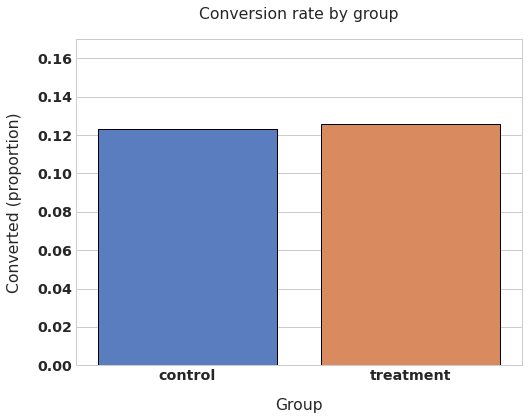

In [ ]:
#visualize Conversion Rate by 'Group'
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

## **Testing Hypothesis**

The last step of our analysis is testing our hypothesis. Since we have a very large sample, we can use the normal approximation for calculating our p-value (i.e. z-test). Python makes all the calculations very easy. We can use the statsmodels.stats.proportion module to get the p-value and confidence intervals

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']
n_control = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_control, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)   #Test for proportions based on normal (z) test
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #check Confidence interval for a binomial proportion

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


## **Conclusion**

Since our p-value=0.732 is way above our α=0.05 threshold (α < p-value), we cannot reject the Null hypothesis (Hₒ), which means that our new design did not perform significantly different than our old one.

Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], or 11.6-13.5%) we notice that:

It includes our baseline value of 13% conversion rate
It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design.